In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Setup

In [108]:
# Uncomment this if using it for the first time. -qqq for ZERO-OUT
!pip3 -qqq install transformers torch datasets
 
# The following two libraries avoid the UnidentifiedImageError
!pip3 -qqq install gdcm
!pip3 -qqq install pydicom
!pip -qqq install faiss-gpu
!pip -qqq install pinecone-client

^C
ERROR: Operation cancelled by user


In [8]:
import os
import faiss
import torch
import skimage
import requests
import pinecone
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import IPython
from IPython.display import Image

## Load dataset

In [109]:
path_to_image="/kaggle/input/flickr8k/Images"
path_to_cpation="/kaggle/input/flickr8k/captions.txt"

In [111]:
caption_df=pd.read_csv(path_to_cpation, sep=',')
caption_df.head(1)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...


In [112]:
caption_df['path']=(path_to_image+'/'+caption_df['image'])

In [113]:
path_sample=list(caption_df.head(1)['path'])[0]
caption_sample=list(caption_df.head(1)['caption'])[0]

A child in a pink dress is climbing up a set of stairs in an entry way .


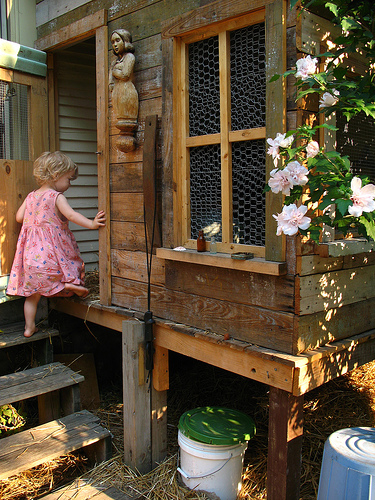

In [114]:

print(caption_sample)
display(IPython.display .Image(filename=path_sample))

In [115]:
caption_df=caption_df[:1000]

## Model 

In [116]:
def get_model_info(model_ID, device):
	model = CLIPModel.from_pretrained(model_ID).to(device)
	processor = CLIPProcessor.from_pretrained(model_ID)
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
	return model, processor, tokenizer

In [117]:

device = "cuda" if torch.cuda.is_available() else "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)
model.to(device)

KeyboardInterrupt: 

In [ ]:
device

#### Text Embedding

In [124]:
def get_single_text_embedding(text): 
    inputs = tokenizer(text, return_tensors = "pt").to(device)
    text_embeddings = model.to(device).get_text_features(**inputs)
     # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np
def get_all_text_embeddings(df, text_col):
    df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)
    return df


In [125]:
# Apply the functions to the dataset
caption_df = get_all_text_embeddings(caption_df, "caption")

In [ ]:
def get_image(image_URL):
   
   image = Image.open(image_URL).convert("RGB")
   return image

In [ ]:
image_data_df = caption_df[['path']]
# Get image from URL
image_data_df["image"] = image_data_df["path"].apply(get_image)

In [ ]:
image_data_df.shape

#### Image embedding

In [ ]:
#from torchvision import transforms, datasets, models

# from IPython.display import Image as IPImage
# image = processor(
#         text = None,
#         images = IPImage('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'),
#         return_tensors="pt"
#         )["pixel_values"].to(device)

In [ ]:
# train_transforms = transforms.Compose(
# [transforms.Resize(255), 
# transforms.CenterCrop(224), 
# transforms.ToTensor(), 
# transforms.RandomHorizontalFlip(), 
# transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [ ]:
# data = datasets.ImageFolder( '/kaggle/input/flickr8k/', transform=train_transforms)


In [118]:
def get_single_image_embedding(my_image):
    image = processor(
        text = None,
        images = my_image,
        return_tensors="pt"
        )["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np
def get_all_images_embedding(df, img_column):
    df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
    return df


In [119]:
image_data_df.head(1)

,path,image,img_embeddings
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,<PIL.Image.Image image mode=RGB size=375x500 a...,"[[-0.0007496476, 0.092358574, -0.088324144, 0...."


In [120]:
image_data_df= get_all_images_embedding(image_data_df, "image")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


In [122]:
caption_df["img_embeddings"] =image_data_df['img_embeddings']

#### results after embedding

In [123]:
caption_df.head(1)

,image,caption,path,img_embeddings
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/kaggle/input/flickr8k/Images/1000268201_693b0...,"[[-0.0007496476, 0.092358574, -0.088324144, 0...."


# Search

In [134]:
from sklearn.metrics.pairwise import cosine_similarity
def get_top_N_images(query, data, top_K=4, search_criterion="text"):
   # Text to image Search
   if(search_criterion.lower() == "text"):
     query_vect = get_single_text_embedding(query)
   # Image to image Search
   else:
     query_vect = get_single_image_embedding(query)
   # Relevant columns
   revevant_cols = ["caption", "path", "cos_sim"]
   # Run similarity Search
   data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))# line 17
   data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
   """
   Retrieve top_K (4 is default value) articles similar to the query
   """
   most_similar_articles = data.sort_values(by='cos_sim',  ascending=False)[1:top_K+1] # line 24
   return most_similar_articles[revevant_cols].reset_index()

In [146]:
def plot_images_by_side(top_images):

  for i,img in top_images.iterrows():   
    print(img['caption'])
    display(IPython.display .Image(filename=img['path']))

In [148]:
query_caption = 'A little girl covered in paint'
# Print the original query text
print("Query: {}".format(query_caption))
# Run the similarity search
top_images = get_top_N_images(query_caption, caption_df,top_K=10)


Query: A little girl covered in paint


In [149]:
top_images

,index,caption,path,cos_sim
0,10,A little girl covered in paint sits in front o...,/kaggle/input/flickr8k/Images/1002674143_1b742...,0.290084
1,14,Young girl with pigtails painting outside in t...,/kaggle/input/flickr8k/Images/1002674143_1b742...,0.290084
2,13,There is a girl with pigtails sitting in front...,/kaggle/input/flickr8k/Images/1002674143_1b742...,0.290084
3,11,A little girl is sitting in front of a large p...,/kaggle/input/flickr8k/Images/1002674143_1b742...,0.290084
4,482,A young girl painting a picture .,/kaggle/input/flickr8k/Images/1105959054_9c3a7...,0.281417
5,483,A young girl with braids is painting with wate...,/kaggle/input/flickr8k/Images/1105959054_9c3a7...,0.281417
6,484,The child paints on a large paper with water c...,/kaggle/input/flickr8k/Images/1105959054_9c3a7...,0.281417
7,481,An artist paints clouds onto a canvas .,/kaggle/input/flickr8k/Images/1105959054_9c3a7...,0.281417
8,480,A child painting a picture .,/kaggle/input/flickr8k/Images/1105959054_9c3a7...,0.281417
9,529,The little girl is playing with a toy in a pub...,/kaggle/input/flickr8k/Images/1115565519_d976d...,0.272409


A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .


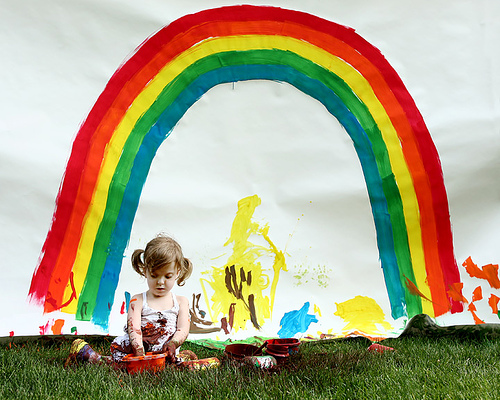

Young girl with pigtails painting outside in the grass .


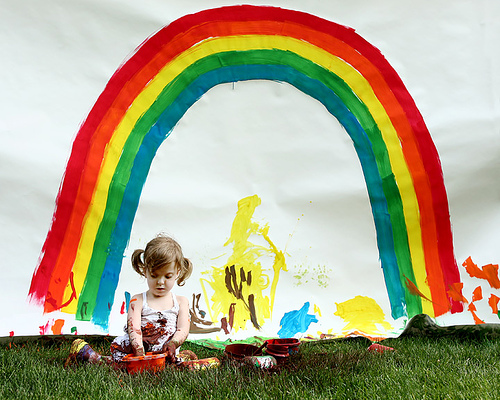

There is a girl with pigtails sitting in front of a rainbow painting .


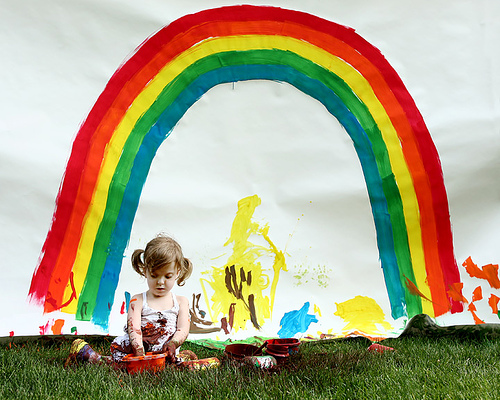

A little girl is sitting in front of a large painted rainbow .


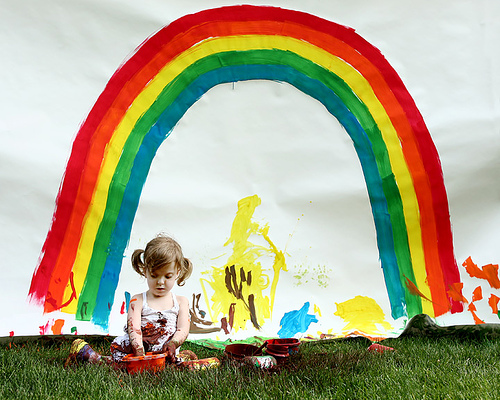

A young girl painting a picture .


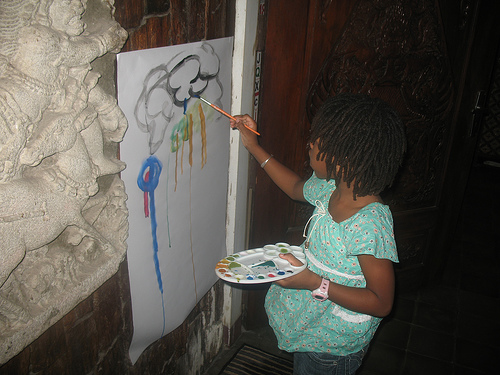

A young girl with braids is painting with water colors on a white paper on the wall .


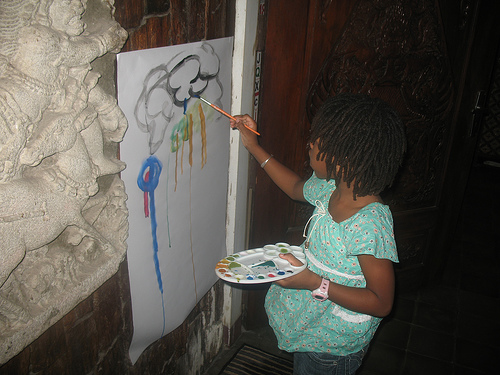

The child paints on a large paper with water colors .


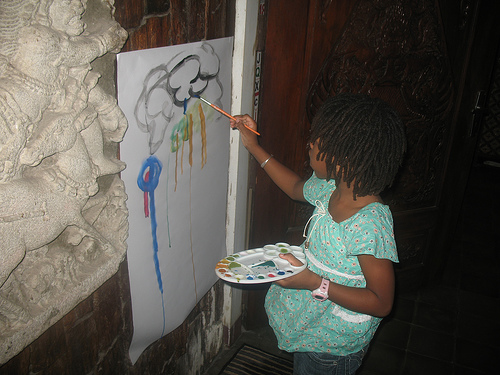

An artist paints clouds onto a canvas .


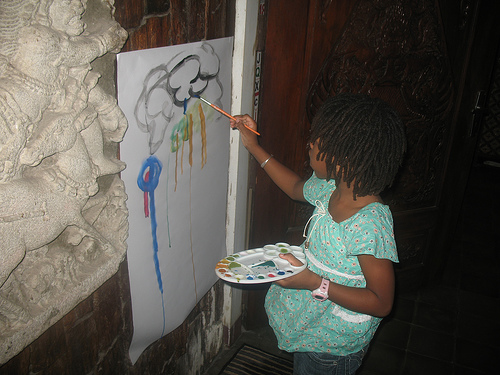

A child painting a picture .


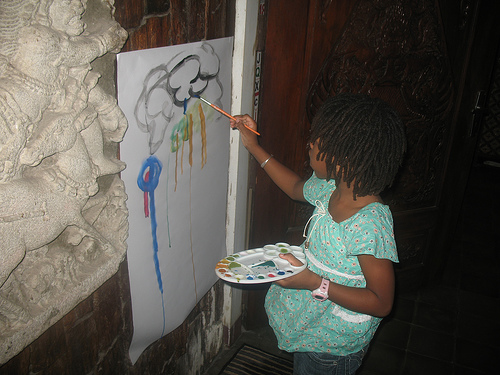

The little girl is playing with a toy in a public fountain .


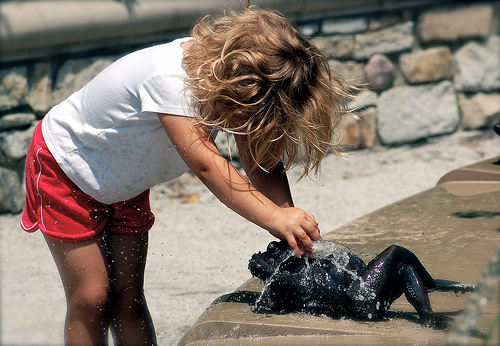

In [150]:
plot_images_by_side(top_images)